In [1]:
import numpy as np
from datetime import datetime, timedelta
import math
from copy import deepcopy
from scipy.stats import norm
import matplotlib.pyplot as plt



# Đủ dữ liệu--------------------------------------------------------------------------------
V = ["Tau1", "Tau2", "Tau3", "Tau4", "Tau5", "Tau6"] #Vessel
B = ["Berth1", "Berth2", "Berth3", "Berth4"] #Berth
VLi = [100, 200, 200, 250, 400, 400] #VLi (Chiều dài tàu i) (mét)
Uiu = False #1 nếu tàu i đi vào kênh ở vị trí u_th khi thủy triều dâng else 0
Viu = False #1 nếu tàu i đi ra khỏi kênh ở phía u_th khi thủy triều dâng else 0
E1 = 2.65 #Hệ số phát thải carbon của xe tải
n_ = 2.14 #Mức tiêu thụ nhiên liệu khi chạy không tải
#pl Mức tiêu thụ nhiên liệu của xe tải khi không tải được xác định bởi tốc độ và tải trọng
#pk Mức tiêu thụ nhiên liệu của xe tải khi đầy tải được xác định bởi tốc độ và tải trọng
E2 = 8.959 #Hệ số chuyển đổi điện năng sang khí thải carbon
lambda1 = 120 #Mức tiêu thụ năng lượng khi cần cẩu làm việc
lambda2 = 12 #Mức tiêu thụ năng lượng khi cần cẩu di chuyển giữa các vị trí
w1 = 0.4 #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
w2 = 0.3 #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
w3 = 0.3 #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
e = 2.71828 #Hằng số logarit
TG0 = float(10)/60 #Thời gian cố định để tàu di chuyển qua kênh
TW0 = 24 #Thời gian chờ tối đa của tàu
VE = [100, 250, 250, 500, 1000, 1000] #Số lượng container tàu chở
CE0 = 0.33333 # Hiệu suất làm việc thực tế của cần cẩu 1 container/giờ
W = 6 #Độ dài mỗi khung thời gian thủy triều cao/thấp
R = 99999 #Một số nguyên đủ lớn để ràng buộc
M = 45 #Tổng số xe tải có thể sử dụng
CF0 = 0.33333 #thời gian để 1 cần cẩu bốc dỡ 1 container (giờ)
vh = np.random.normal(loc=25, scale=4) #Tốc độ xe tải khi không tải
vl = np.random.normal(loc=18, scale=3) #Tốc độ khi xe container quá tải
VDi = [5 ,8, 8, 15, 30, 30] #VDi (Mớn nước của tàu i) (mét)
VCmi = [1, 1, 1, 1, 1, 1] #VCmi (Số cần cẩu tối thiểu cho tàu i ) (chiếc)
VCMi = [3, 3, 3, 4, 5, 5] #VCMi (Số cần cẩu tối đa cho tàu i) (chiếc)
Dij = [[1831, 2290, 2574, 3031],
       [2499, 1934, 2139, 2566],
       [2499, 1934, 2139, 2566],
       [3114, 2535, 2054, 2922],
       [3157, 2861, 2273, 2015],
       [3157, 2861, 2273, 2015]] #Dij: Khoảng cách từ tàu i (tại bến j) đến bãi đích, đơn vị km       
BLj = [400, 400, 300, 300] #BLj (Chiều dài của bến j ) (mét)
BDj = [20, 20, 15 ,15] #BDj (Mớn nước tại bến j ) (mét)

#Thiếu dữ liệu-------------------------------------------------------------------
VmL = [] #nhóm tàu lớn đang cập cảng
CKnt = [] #tập hợp số lượng xe tải phục vụ cẩu tại bến n thời điểm t 

# Dữ liệu tùy chọn---------------------------------------------------------------
xijk = [] #1 nếu tàu i phục vụ theo trình tự k tại bến j else 0
qitn = [] #1 nếu cần cẩu cầu cảng n phục vụ cho tàu i trong thời gian t else 0
u_iu = [] # Biến nhị phân biểu thị khung thời gian tàu có thể vào
v_iu = [] # Biến nhị phân biểu thị khung thời gian tàu có thể ra
TH = [float(300)/vh, float(350)/vh, float(450)/vh, float(500)/vh] #Thời gian xe tải rỗng ddi  300 350 450 500
TL = [float(300)/vl, float(350)/vl, float(450)/vl, float(500)/vl] #Thời gian vận chuyển hàng hóa nặng bằng xe tải
VCit = [3, 3, 3, 4, 5, 5] #Số lượng cần cẩu phục vụ
T = [i for i in range(1,25)]
Tt = ["3:00:00 - 6:00:00", "15:00:00 - 18:00:00"] #Khung thoi gian thuy trieu cao
C = [i for i in range(1, 24)] #Crane
Y = [i for i in range(1, 46)] #Truck
l1 = np.random.normal(loc=15.75, scale=1.25) #Tải trọng của xe khi không tải 
l2 = np.random.normal(loc=33.5, scale=1.5) #Tải trọng của xe khi đầy tải 
TOi = ["30/12/2018 18:00:00", "31/12/2018 22:00:00", "02/01/2019 04:00:00", "02/01/2019 23:00:00", "03/01/2019 20:30:00", "04/01/2019 07:00:00"]  # Thời gian dự kiến tàu đến
x = [0.8, 0.6, 1.0, 0.5, 0.4, 1.2]  # thời gian chờ vào bến (giờ)
delTA = []  # Độ lệch thời gian dựa trên Erlang
TAi = []    # Thời gian đến thực tế sau khi cộng độ lệch
u_TA = 1.0 / (sum(x) / len(x))
kTA = 3
TF = ["01/01/2019 03:50:00", "03/01/2019 00:00:00", "03/01/2019 23:00:00", "04/01/2019 06:00:00", "04/01/2019 13:00:00", "05/01/2019 12:00:00"] #Khoảng thời gian tàu đi
TE = [] #thời gian khởi hành của tàu đi ra khỏi kênh khi rời cảng
TDTS = []

# OUTPUT
VO = [] #tập hợp các thứ tự của tàu thuyền vào cảng
VB = [] #Bến tàu i sẽ cập
VC = [] #Số cần cẩu phân bổ cho tàu i
VK = [] #Số xe tải phân bổ cho tàu i

def calculate_pvl(v, l):
    a = 0.02
    b = -1.67
    c = 0.46
    d = 0.03
    e = 51.17
    return a * v * v + b * v + c * l + d * v * l + e
Dl = float(500) / calculate_pvl(vh, l1) * 100 #Tổng quãng đường xe tải đi được khi không có hàng dung tích bình 500l
Dk = float(500) / calculate_pvl(vl, l2) * 100#Tổng quãng đường xe tải chở hàng nặng đã đi
tn_ = float(Dl) / vh #Tổng thời gian xe tải chạy không tải tiêu thụ nhiên liệu

def calculate_con13():
    #Sum VCit: tong so can cau phan bo trong suot qua trinh -> = VCMi
    for i in range(len(VE)):
        TDTS.append(float(VE[i])/(CE0 * VCit[i]))
        
calculate_con13()
print(TDTS)

def convert_time_to_float(time_str):
    dt = datetime.strptime(time_str, "%d/%m/%Y %H:%M:%S")
    return dt.year * 12 * 30 * 24 + dt.month * 30 * 24 + dt.day * 24 + dt.hour + dt.minute / 60.0 + dt.second / 3600.0

# def convert_time_to_float(time_input):
#     if isinstance(time_input, datetime):
#         dt = time_input
#     elif isinstance(time_input, str):
#         dt = datetime.strptime(time_input, "%d/%m/%Y %H:%M:%S")
#     else:
#         raise TypeError("Input must be a string or datetime object.")
    
#     epoch = datetime(1970, 1, 1)
#     delta = dt - epoch
#     return delta.total_seconds()

TO_float = [convert_time_to_float(t) for t in TOi]

def calculate_fErlang():
    for i in range(len(x)):
        fxku_ = (pow(u_TA * x[i], kTA - 1) * np.exp(-u_TA * x[i]))
        fxku_ /= math.factorial(kTA - 1)
        delTA.append(fxku_)
    return delTA

def calculate_TA(TO_float, delTAi):
    lst = [TO_float[i] + delTAi[i] for i in range(len(TO_float))]
    return lst

calculate_fErlang()
TAi = calculate_TA(TO_float, delTA)

TF_float = [convert_time_to_float(t) for t in TF]

for i in range(len(TF_float)):
    TE.append(TF_float[i] - TG0)

TAi_float = [float(i) for i in TAi]

print([float(i) for i in delTA])
print(TO_float)
print(TF_float)
print(TAi_float)
print(TE)

TB = [TAi_float[i] + 0.25 for i in range(len(TAi_float))]
TC = [TB[i] + TG0 for i in range(len(TB))] #Thời điểm tàu i đã vào cảng
TS = [TC[i] + float(10)/60 for i in range(len(TC))]     #Thời gian bắt đầu công việc cho tàu
print(TC)
print(TS)
TV = TS #Thời gian bắt đầu hỗ trợ từ cần cẩu lân cận cho tàu = TS
TD = [TDTS[i] + TS[i] for i in range(len(TDTS))]
print(TD)
VC = [1, 1, 1, 1, 1, 1] #Số lượng cần cẩu được phân công cố định cho tàu
delVCit = [VCMi[i] - VCmi[i] for i in range(len(VCMi))] # Số lượng cần cẩu di chuyển từ bến lân cận để hỗ trợ tàu i tại thời điểm t = VCMi - VCmi


def float_to_datetime(float_time):
    epoch = datetime(1970, 1, 1)
    return epoch + timedelta(seconds=float_time)

E1 = 2.65 #Hệ số phát thải carbon của xe tải
n_ = 2.14 #Mức tiêu thụ nhiên liệu khi chạy không tải
E2 = 8.959 #Hệ số chuyển đổi điện năng sang khí thải carbon
vh = np.random.normal(loc=25, scale=4) #Tốc độ xe tải khi không tải
vl = np.random.normal(loc=18, scale=3) #Tốc độ khi xe container quá tải
TH = [float(300)/vh, float(350)/vh, float(450)/vh, float(500)/vh] #Thời gian xe tải rỗng ddi  300 350 450 500
TL = [float(300)/vl, float(350)/vl, float(450)/vl, float(500)/vl] #Thời gian vận chuyển hàng hóa nặng bằng xe tải
l1 = np.random.normal(loc=15.75, scale=1.25) #Tải trọng của xe khi không tải 
l2 = np.random.normal(loc=33.5, scale=1.5) #Tải trọng của xe khi đầy tải 



[100.0010000100001, 250.00250002500024, 250.00250002500024, 375.00375003750037, 600.0060000600006, 600.0060000600006]
[0.19578526541676794, 0.1437852685175109, 0.23430856721397933, 0.11409269311835378, 0.0834341289969823, 0.2584275430331589]
[17444898.0, 17444926.0, 17444932.0, 17444951.0, 17444972.5, 17444983.0]
[17444907.833333332, 17444952.0, 17444975.0, 17444982.0, 17444989.0, 17445012.0]
[17444898.195785265, 17444926.143785268, 17444932.234308567, 17444951.114092693, 17444972.583434127, 17444983.25842754]
[17444907.666666664, 17444951.833333332, 17444974.833333332, 17444981.833333332, 17444988.833333332, 17445011.833333332]
[17444898.612451933, 17444926.560451936, 17444932.650975235, 17444951.53075936, 17444973.000100795, 17444983.67509421]
[17444898.7791186, 17444926.727118604, 17444932.817641903, 17444951.69742603, 17444973.166767463, 17444983.841760878]
[17444998.78011861, 17445176.729618628, 17445182.820141926, 17445326.701176066, 17445573.172767524, 17445583.847760938]


Iter 1, Best Fitness: 8200147562.48096
Iter 2, Best Fitness: 8200147562.48096
Iter 3, Best Fitness: 8200047565.119639
Iter 4, Best Fitness: 8200047565.119639
Iter 5, Best Fitness: 8200047565.119639
Iter 6, Best Fitness: 8200047564.686709
Iter 7, Best Fitness: 8199947566.119639
Iter 8, Best Fitness: 8199947566.119639
Iter 9, Best Fitness: 8199947566.119639
Iter 10, Best Fitness: 8199947566.119639
Iter 11, Best Fitness: 8199947566.119639
Iter 12, Best Fitness: 8199947566.119639
Iter 13, Best Fitness: 8199947566.119639
Iter 14, Best Fitness: 8199947566.119639
Iter 15, Best Fitness: 8199947566.119639
Iter 16, Best Fitness: 8199947566.119639
Iter 17, Best Fitness: 8199947566.119639
Iter 18, Best Fitness: 8199947566.119639
Iter 19, Best Fitness: 8199947566.119639
Iter 20, Best Fitness: 8199947566.119639
Iter 21, Best Fitness: 8199947566.119639
Iter 22, Best Fitness: 8199947566.119639
Iter 23, Best Fitness: 8199947566.119639
Iter 24, Best Fitness: 8199947565.921419
Iter 25, Best Fitness: 8199

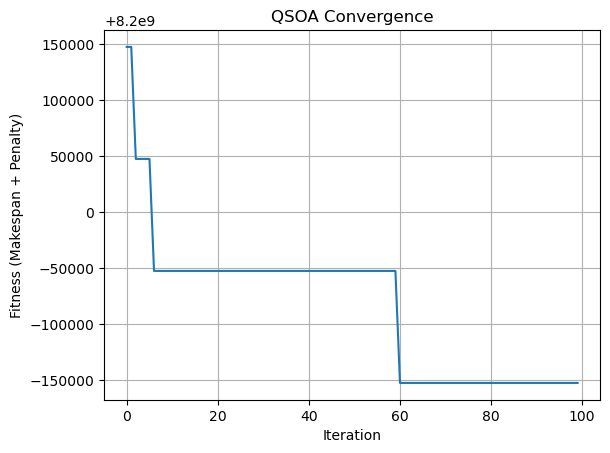


Best Solution:
1. Phân bổ tàu-bến (x):
[[0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]]

2. Phân bổ cần cẩu (q):
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0]
 [0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0]]

3. Phân bổ xe (y):
[[0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0
  1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0
  0 0 0 0 1 0 0 1 0]
 [0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0
  0 0 0 1 0 1 0 0 0]
 [1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0
  0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 

In [7]:
np.random.seed(42)
V = 6   # Số tàu
B = 4   # Số bến
C = 23  # Số cần cẩu
Y = 45  # Số xe
M = 99999  # Penalty
TW0 = 24  # Thời gian chờ tối đa (h)
T = 24
CK = np.random.randint(0, 4, size=(C, T))

# --- Copy các biến, hàm ràng buộc, fitness từ test.ipynb vào đây ---
# (bao gồm: các biến dữ liệu, enforce_crane_constraints, schedule_cranes, check_truck_constraints, build_CK_A_from_sol, calc_carbon_emission, fitness...)
# Dữ liệu đầu vào
def convert_time_to_float(time_input):
    if isinstance(time_input, datetime):
        dt = time_input
    elif isinstance(time_input, str):
        dt = datetime.strptime(time_input, "%d/%m/%Y %H:%M:%S")
    else:
        raise TypeError("Input must be a string or datetime object.")
    
    epoch = datetime(1970, 1, 1)
    delta = dt - epoch
    return delta.total_seconds()

TAi_float = [convert_time_to_float(i) for i in TOi]
TF_float = [convert_time_to_float(i) for i in TF]
# Thời gian đến (TA) và thời gian xử lý dự kiến (PT)
TA = np.array(TAi_float)  # Giờ
PT = np.array(np.array(TF_float) - np.array(TAi_float))    # Giờ

D = np.array(np.array(Dij) / 1000)
DMN = 14
# ==================== HÀM NGOÀI CLASS ====================
def enforce_crane_constraints(q):
    for i in range(V):
        num_assigned = np.sum(q[i])
        if num_assigned < VCmi[i]:
            available = np.where(q[i] == 0)[0]
            to_add = VCmi[i] - num_assigned
            selected = np.random.choice(available, to_add, replace=False)
            q[i, selected] = 1
        elif num_assigned > VCMi[i]:
            assigned = np.where(q[i] == 1)[0]
            to_remove = num_assigned - VCMi[i]
            selected = np.random.choice(assigned, to_remove, replace=False)
            q[i, selected] = 0
    return q

def schedule_cranes(q2D, VE, CF0, T):
    V, C = q2D.shape
    q3D = np.zeros((V, C, T), dtype=int)

    for i in range(V):  # mỗi tàu
        assigned_cranes = np.where(q2D[i] == 1)[0]
        num_cranes = len(assigned_cranes)
        
        if num_cranes == 0:
            continue

        total_time = int(np.ceil(VE[i] * CF0))  # tính tổng thời gian cần cẩu phục vụ tàu
        duration = total_time // num_cranes
        extra = total_time % num_cranes
        start_time = 0  # có thể đặt tùy theo lịch cập nhật nếu cần

        for j, c in enumerate(assigned_cranes):
            dur = duration + (1 if j < extra else 0)
            end_time = min(start_time + dur, T)
            q3D[i][c][start_time:end_time] = 1
            start_time = end_time  # tiếp nối cần cẩu kế tiếp

    return q3D

def crane_non_crossing_constraint(q):
    for i in range(V):
        for n in range(1, C - 1):
            for t in range(T):
                left = q[i][n - 1][t]
                center = q[i][n][t]
                right = q[i][n + 1][t]
                if left == 1 and right == 1 and center == 0:
                    return False
    return True

def check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, CE0):
    C, T = CK.shape
    V, B = D.shape
    
    for t in range(T):
        total_trucks = np.sum(CK[:, t])
        if total_trucks > M:
            return False

    v_h = norm.rvs(mu_vh, sigma_vh)
    v_l = norm.rvs(mu_vl, sigma_vl)

    TH = D / v_h  # Thời gian không tải
    TL = D / v_l  # Thời gian có tải

    # Ràng buộc (37): Hiệu suất cần cẩu không vượt ngưỡng
    for n in range(C):
        for t in range(T):
            i, j = A[n, t]  # Tàu i ở bến j mà cần cẩu n phục vụ tại t
            ck = CK[n, t]

            if ck == 0:
                continue  # Không có xe tải → bỏ qua

            # Tính hiệu suất của cần cẩu
            denominator = max(TH[i, j] + TL[i, j] + 1/CF0, ck / CE0)
            CE_n = ck / denominator

            if CE_n > CE0:
                return False

    return True

def check_vessel_berth_length_constraint(x, VLi, BLj):
    V, B = x.shape
    for i in range(V):
        for j in range(B):
            if x[i][j] == 1 and VLi[i] > BLj[j]:
                return False
    return True

def parse_tide_intervals(Tt):
    intervals = []
    for interval in Tt:
        start_str, end_str = interval.split(" - ")
        h1, m1, s1 = map(int, start_str.split(":"))
        h2, m2, s2 = map(int, end_str.split(":"))
        start = timedelta(hours=h1, minutes=m1, seconds=s1)
        end = timedelta(hours=h2, minutes=m2, seconds=s2)
        intervals.append((start, end))
    return intervals

def is_high_tide(dt, tide_intervals):
    current_time = timedelta(hours=dt.hour, minutes=dt.minute, seconds=dt.second)
    for start, end in tide_intervals:
        if start <= current_time <= end:
            return True
    return False

def next_high_tide_time(dt, tide_intervals):
    for day_offset in range(0, 3):  # thử tối đa 3 ngày sau
        new_date = dt.date() + timedelta(days=day_offset)
        for start, _ in tide_intervals:
            candidate = datetime.combine(new_date, (datetime.min + start).time())
            if candidate > dt:
                return candidate
    return dt + timedelta(hours=6)  # fallback

def float_to_datetime(float_time):
    epoch = datetime(1970, 1, 1)
    return epoch + timedelta(seconds=float_time)

def build_CK_A_from_sol(sol, V, C, T, B):
    CK = np.zeros((C, T), dtype=int)
    A = np.zeros((C, T, 2), dtype=int)
    for i in range(V):
        assigned_cranes = np.where(sol['q'][i] == 1)[0]
        assigned_trucks = np.where(sol['y'][i] == 1)[0]
        berth = np.argmax(sol['x'][i])
        for n in assigned_cranes:
            for t in range(T//2):
                CK[n, t] += max(1, len(assigned_trucks)//max(1, len(assigned_cranes)))
                A[n, t] = [i, berth]
    return CK, A

def calc_carbon_emission(sol, V, C, T, D, E1, E2):
    carbon_truck = 0
    carbon_crane = 0
    for i in range(V):
        assigned_cranes = np.where(sol['q'][i] == 1)[0]
        assigned_trucks = np.where(sol['y'][i] == 1)[0]
        berth = np.argmax(sol['x'][i])
        carbon_truck += len(assigned_trucks) * D[i, berth] * 2 * E1
        carbon_crane += len(assigned_cranes) * (T//2) * E2
    return carbon_truck, carbon_crane

def enforce_crane_constraints_optimized(q, VCmi, VCMi, carbon_emission_matrix=None):
    for i in range(q.shape[0]):  # với mỗi tàu
        num_assigned = np.sum(q[i])
        if num_assigned < VCmi[i]:
            available = np.where(q[i] == 0)[0]
            # Ưu tiên chọn cần cẩu có phát thải thấp nhất
            if carbon_emission_matrix is not None:
                sorted_idx = available[np.argsort(carbon_emission_matrix[i, available])]
            else:
                sorted_idx = available
            to_add = VCmi[i] - num_assigned
            selected = sorted_idx[:to_add]
            q[i, selected] = 1
        elif num_assigned > VCMi[i]:
            assigned = np.where(q[i] == 1)[0]
            # Loại bỏ cần cẩu có phát thải cao nhất
            if carbon_emission_matrix is not None:
                sorted_idx = assigned[np.argsort(-carbon_emission_matrix[i, assigned])]
            else:
                sorted_idx = assigned
            to_remove = num_assigned - VCMi[i]
            selected = sorted_idx[:to_remove]
            q[i, selected] = 0
    return q

# === HÀM QUANTUM GATE ===
def quantum_revolving_gate(phi, delta_phi):
    return phi + delta_phi

def quantum_not_gate(phi):
    return np.pi/2 - phi

# === QSOA CLASS ===
class QuantumSeagullOptimization:
    def __init__(self, n_seagulls=50, max_iter=200, pm=0.1):
        self.n_seagulls = n_seagulls
        self.max_iter = max_iter
        self.pm = pm  # probability of NOT gate

    def initialize(self):
        self.population_phi = []
        for _ in range(self.n_seagulls):
            phi = {
                'x': np.random.uniform(0, 2*np.pi, (V, B)),
                'q': np.random.uniform(0, 2*np.pi, (V, C)),
                'y': np.random.uniform(0, 2*np.pi, (V, Y))
            }
            self.population_phi.append(phi)
            
    @staticmethod
    def enforce_truck_constraints_optimized(y, num_trucks, min_truck_per_vessel=1, max_truck_per_vessel=10):
        V, M = y.shape
        # Step 1: Ensure each vessel has at least min_truck_per_vessel trucks, not exceeding max_truck_per_vessel
        for i in range(V):
            current = np.sum(y[i])
            if current < min_truck_per_vessel:
                available = np.where(np.sum(y, axis=0) == 0)[0]
                to_add = min_truck_per_vessel - current
                if len(available) >= to_add:
                    selected = np.random.choice(available, to_add, replace=False)
                    y[i, selected] = 1
                else:
                    selected = np.random.choice(M, to_add, replace=False)
                    y[i, selected] = 1
            if np.sum(y[i]) > max_truck_per_vessel:
                assigned = np.where(y[i] == 1)[0]
                to_remove = np.sum(y[i]) - max_truck_per_vessel
                selected = np.random.choice(assigned, to_remove, replace=False)
                y[i, selected] = 0

        # Step 2: Prioritize truck allocation for vessels with more cranes
        # if hasattr(self, 'last_q'):
        #     cranes_per_vessel = np.sum(self.last_q, axis=1)
        #     sort_idx = np.argsort(-cranes_per_vessel)  # tàu nhiều cần cẩu trước
        # else:
        sort_idx = np.arange(V)
        # Bước 3: Nếu tổng số xe vượt quá num_trucks, loại bớt xe từ tàu ít cần cẩu hơn
        while np.sum(y) > num_trucks:
            for i in reversed(sort_idx):
                assigned = np.where(y[i] == 1)[0]
                if len(assigned) > min_truck_per_vessel:
                    y[i, assigned[0]] = 0
                    break
            else:
                break
        # Bước 4: Nếu tổng số xe còn thiếu, phân bổ thêm cho tàu nhiều cần cẩu hơn
        while np.sum(y) < num_trucks:
            for i in sort_idx:
                assigned = np.where(y[i] == 0)[0]
                if np.sum(y[i]) < max_truck_per_vessel and len(assigned) > 0:
                    y[i, assigned[0]] = 1
                    break
            else:
                break
        return y
        
    
    def phi_to_solution(self, phi):
        x_bin = (np.cos(phi['x']) > 0).astype(int)
        for i in range(x_bin.shape[0]):
            if np.sum(x_bin[i]) != 1:
                idx = np.argmax(phi['x'][i])
                x_bin[i] = 0
                x_bin[i, idx] = 1
        q_bin = (np.cos(phi['q']) > 0).astype(int)
        q_bin = enforce_crane_constraints_optimized(q_bin, VCmi, VCMi)
        y_bin = (np.cos(phi['y']) > 0).astype(int)
        y_bin = self.enforce_truck_constraints_optimized(y_bin, M)
        return {'x': x_bin, 'q': q_bin, 'y': y_bin}

    def fitness(self, sol):
        makespan = 0
        penalty = 0
        completion_times = []
        berth_schedule = {j: 0.0 for j in range(B)}
        tide_intervals = parse_tide_intervals(Tt)

        tide_intervals = parse_tide_intervals(Tt)  # Giả định Tt là một danh sách ["3:00:00 - 6:00:00", ...]

        # Ràng buộc 1: Mỗi tàu chỉ vào 1 bến
        for i in range(V):
            if sum(sol['x'][i]) != 1:
                penalty += M

        # Ràng buộc 2: Mỗi cần cẩu chỉ phục vụ 1 tàu tại 1 thời điểm
        for n in range(C):
            if sum(sol['q'][:, n]) > 1:
                penalty += M

        for i in np.argsort(TA):  # xử lý theo thứ tự tàu đến
            berth = np.argmax(sol['x'][i])
            assigned_cranes = np.sum(sol['q'][i])
            assigned_trucks = np.sum(sol['y'][i])

            if VDi[i] > BDj[berth]:
                penalty += M

    # Ràng buộc chiều dài
            if VLi[i] > BLj[berth]:
                penalty += M

            if assigned_cranes == 0 or assigned_trucks == 0:
                penalty += M
                continue

            # Kiểm tra điều kiện thủy triều
            arrival_dt = float_to_datetime(TA[i])
            if VDi[i] > DMN:
                # Tàu lớn: chỉ được cập cảng/xuất cảng trong khung giờ thủy triều cao
                if not is_high_tide(arrival_dt, tide_intervals):
                    arrival_dt = next_high_tide_time(arrival_dt, tide_intervals)
                TA_adjusted = convert_time_to_float(arrival_dt)
            else:
                # Tàu nhỏ: cập cảng bất kỳ lúc nào
                TA_adjusted = TA[i]


            start_time = max(float(TA_adjusted), float(berth_schedule[berth]))
            waiting_time = start_time - TA[i]
            if waiting_time > TW0:
                penalty += M * (waiting_time - TW0)

            processing_time = float((VE[i] * CF0) / assigned_cranes)
            transport_delay = D[i, berth] / (assigned_trucks + 1e-5)
            completion = float(start_time + processing_time + transport_delay)


            completion_times.append(completion)
            berth_schedule[berth] = completion
            
        # Ràng buộc: Cần cẩu không nhảy qua nhau
        q3D = schedule_cranes(sol['q'], VE, CF0, T)
        if not crane_non_crossing_constraint(q3D):
            penalty += M

        # Ràng buộc: Chiều dài tàu không vượt chiều dài bến
        if not check_vessel_berth_length_constraint(sol['x'], VLi, BLj):
            penalty += M

                # === BƯỚC 1: Xây dựng CK, A ===
        CK, A = build_CK_A_from_sol(sol, V, C, T, B)
        # === BƯỚC 2: Kiểm tra ràng buộc xe tải ===
        mu_vh, sigma_vh = 25, 4
        mu_vl, sigma_vl = 18, 3
        if not check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, E2):
            penalty += M * 10
        # === BƯỚC 3: Tính khí thải carbon ===
        carbon_truck, carbon_crane = calc_carbon_emission(sol, V, C, T, D, E1, E2)
        w_carbon = 0.01
        makespan = max(completion_times) if completion_times else M
        fitness_value = makespan + w_carbon * (carbon_truck + carbon_crane) + penalty
        if fitness_value < 0:
            fitness_value = 1e12  # hoặc giá trị lớn dương
        return fitness_value

    def optimize(self):
        self.initialize()
        fitness_history = []
        best_phi = min(self.population_phi, key=lambda phi: self.fitness(self.phi_to_solution(phi)))
        best_sol = self.phi_to_solution(best_phi)

        for iter in range(self.max_iter):
            new_population_phi = []
            best_phi = min(self.population_phi, key=lambda phi: self.fitness(self.phi_to_solution(phi)))
            new_population_phi.append(best_phi)
            for phi in self.population_phi:
                # --- Quantum Revolving Gate update ---
                delta_phi_x = np.random.uniform(-np.pi/16, np.pi/16, phi['x'].shape)
                delta_phi_q = np.random.uniform(-np.pi/16, np.pi/16, phi['q'].shape)
                delta_phi_y = np.random.uniform(-np.pi/16, np.pi/16, phi['y'].shape)
                phi_new = {
                    'x': quantum_revolving_gate(phi['x'], delta_phi_x),
                    'q': quantum_revolving_gate(phi['q'], delta_phi_q),
                    'y': quantum_revolving_gate(phi['y'], delta_phi_y)
                }
                # --- Quantum NOT Gate (với xác suất pm) ---
                if np.random.rand() < self.pm:
                    phi_new['x'] = quantum_not_gate(phi_new['x'])
                    phi_new['q'] = quantum_not_gate(phi_new['q'])
                    phi_new['y'] = quantum_not_gate(phi_new['y'])
                new_population_phi.append(phi_new)
            self.population_phi = new_population_phi
            best_phi = min(self.population_phi, key=lambda phi: self.fitness(self.phi_to_solution(phi)))
            best_sol = self.phi_to_solution(best_phi)
            fitness_history.append(self.fitness(best_sol))
            
            print(f"Iter {iter+1}, Best Fitness: {fitness_history[-1]}")
        plt.plot(fitness_history)
        plt.title("QSOA Convergence")
        plt.xlabel("Iteration")
        plt.ylabel("Fitness (Makespan + Penalty)")
        plt.grid(True)
        plt.show()
        return best_sol

# --- Hướng dẫn sử dụng ---
qsoa = QuantumSeagullOptimization(n_seagulls=30, max_iter=100)
best_solution = qsoa.optimize()
print("\nBest Solution:")
print("1. Phân bổ tàu-bến (x):")
print(best_solution['x'])

print("\n2. Phân bổ cần cẩu (q):")
print(best_solution['q'])

print("\n3. Phân bổ xe (y):")
print(best_solution['y'])

berth_schedule = {j: 0 for j in range(B)}
print("\nChi tiết thời gian:")
for i in np.argsort(TA):
    berth = np.argmax(best_solution['x'][i])
    start = max(TA[i], berth_schedule[berth])
    wait = start - TA[i]
    end = start + PT[i]
    def schedule_cranes(num_containers, num_cranes, cf0=CF0):
        if num_cranes == 0:
            return float('inf')  # Không có cần cẩu thì không thể bốc dỡ
        return num_containers * cf0 / num_cranes

    num_cranes = int(np.sum(best_solution['q'][i])) if 'q' in best_solution else 1
    handling_time = schedule_cranes(VE[i], num_cranes)
    end = TA[i] + handling_time
    print(f"Tàu {i}: Bến {berth}, Đến {float_to_datetime(TA[i])}h, Bắt đầu {float_to_datetime(start)}h, Chờ {wait / 3600}h, Thời điểm kết thúc dự kiến: {float_to_datetime(end)}h")
    berth_schedule[berth] = start + PT[i]

makespan = (max(berth_schedule.values()) - min(TA)) / 3600  # Đơn vị: giờ
print(f"Makespan thực tế: {makespan:.2f} giờ")